In [1]:
#IMPORTS
import os
import sys
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
import scipy.io.wavfile
import time
from tensorflow.python.tools import freeze_graph
from tensorflow.keras import layers
import tensorflow.keras as kr
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
#Create directory of experiment and tf_logs/run-X
modelName = "Code_v1"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
	
# directory that will contain tensorboard information
pathLog = 'tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

version 2.0.0 of tensorflow


In [3]:
#############################
# Model parameters
#############################
trainTestRatio = 0.7
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = int(np.floor(44100*2.7))#11.4
num_step = 100                                         #time step
num_hidden = 200                                      #num of hidden units
num_class = 1                                          #size of the output
num_feature = 1                                        # size of the input
batch_size = 300    #300                                  # number of sequence taken before to compute the gradient
n_layer =1                                             #num_layer
num_epoch = 30     #100000                                 # process all the datas num_epoch times
trainDuration = 2     #60                         # or during a determined duration(second)
fileName = 'training.mat'             #dataset train/test path
fileNameValidation = 'validation.mat' # dataset validation path

In [4]:
#############################
# Loading data
#############################
matrix = sio.loadmat(fileName)
matrix = matrix['training']
if maxSize ==0:
    maxSize = len(matrix)
    print(maxSize)
# to do shuffle matrix by num_step length
train_input,train_output,test_input,test_output = splitShuffleData(matrix,num_step,trainTestRatio,maxSize,1)
###############################
#   validation dataset and emulate guitar signal
###############################
matrixVal = sio.loadmat(fileNameValidation)
matrixVal = matrixVal['validation']
val_input,val_output = shapeData(matrixVal,num_step,maxSize,1)
val_input_listen,val_output_not = shapeData(matrixVal,1,maxSize,1)
print("shape IN train {}".format(np.shape(train_input)))
print("shape OUT train {}".format(np.shape(train_output)))
print("shape IN test {}".format(np.shape(test_input)))
print("shape OUT test {}".format(np.shape(test_output)))
print("shape IN val {}".format(np.shape(val_input)))
print("shape OUT val {}".format(np.shape(val_output)))
print ("Data loaded")

shape IN train (83349, 100, 1)
shape OUT train (83349, 1, 1)
shape IN test (35621, 100, 1)
shape OUT test (35621, 1, 1)
shape IN val (118970, 100, 1)
shape OUT val (118970, 1, 1)
Data loaded


In [5]:
model=0
model = tf.keras.Sequential()
model.add(kr.layers.LSTM(32,input_shape=(num_step,num_feature),return_sequences=False))
model.add(kr.layers.Dense(32, activation='relu'))
model.add(kr.layers.Dense(1, activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, verbose=0)
]

model.compile(loss='mse', optimizer=kr.optimizers.SGD(lr=0.05), metrics=['acc'])
model.fit(train_input,train_output, epochs=num_epoch, callbacks=callbacks)
model.evaluate(test_input, test_output)
model.summary()

Train on 83349 samples
Epoch 1/3
83349/83349 [==============================] - 83s 992us/sample - loss: 0.0635 - acc: 0.0000e+00
Epoch 2/3
  160/83349 [..............................] - ETA: 1:42 - loss: 0.0549 - acc: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


83349/83349 [==============================] - 83s 997us/sample - loss: 0.0516 - acc: 0.0000e+00
Epoch 3/3
83349/83349 [==============================] - 78s 930us/sample - loss: 0.0478 - acc: 0.0000e+00
35621/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predictions = model.predict(np.array(val_input))

<IPython.core.display.Javascript object>


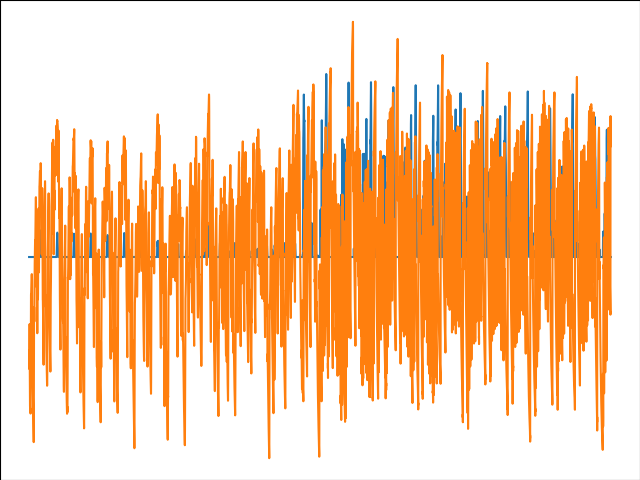

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.38560042]
 [0.37388527]
 [0.35270518]]
(118970, 1)
(119069, 1, 1)
(118970, 100, 1)


In [13]:
toPrint=predictions
import math
%matplotlib notebook
x=np.arange(0,150000,1)
fig=plt.figure()
ax=fig.add_axes([0,0, 1 , 1 ])

val=val_output_not.reshape(len(val_output_not),1)
ax.plot(toPrint[1000:15000])
ax.plot(val[1000:15000])


print(predictions.shape)
print(val_output_not.shape)
print(val_input.shape)

scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,val_output)
scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictions)
scipy.io.wavfile.write(os.path.join(path,'input.wav'),44100,val_input_listen)